In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import *
from sklearn.datasets.mldata import fetch_mldata
import tempfile
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn import linear_model as lm
from anytime_regression import *

In [83]:
lam = np.logspace(-5,5,100) 

**Synthetic Experiment** --- **Catogorical Data**

**Data Generation**:                                                                                                    
1) First generate y: randomly pick up 1 or -1.                                                                                
2) Initialize all x1 and x2 with same value of y.                                                                      
3) Randomly flip 10% of x1 and 40% of x2 --- x1 is better feature with 90% accuracy while x2 has 60% accuracy.             
4) Set the probability for each feature to show up at prediction as (0.2 and 0.9)                                      
5) Finished.

Joey: I found your generate_synthetic_data code a bit too complicated for me so I have created a new synthetic dataset generator.  Would be good to know how they differ in the data. (Probably the same?)

```
### Generate Dataset
n = 5000 #number of training data and testing data respectively
d = 2
p = np.array([0.2,0.9]) ## x1 has 90% accuracy and x2 has 60% accuracy
X_train,y_train = generate_synthetic_data(n,d,p)
X_test_o,y_test = generate_synthetic_data(n,d,p)
X_test = modify_data(X_test_o,X_train,p)
X_val,y_val = generate_synthetic_data(n,d,p)
```

In [75]:
#import numpy.matlib
n = 10000
d = 10
propTrain = 0.8
# The probability that the feature will _disagree_ with the label
pError = 0.3 * np.ones(d) # currently all uniform
# Probability of missing a dimension at test time
pMissing = 0.8 * np.ones(d)
# Make first dimension a safe dimension (occurs often)
pMissing[0] = 0.2 

# Construct raw training data
y = np.random.choice([-1., 1.], (n,))
X = np.array([y * np.random.choice([-1., 1.], size=(n,), p=[p, 1. - p]) for p in pError]).T
# Normalize the raw data for simplicity
X = X - X.mean(axis = 0)
X = X / X.var(axis = 0)

# Split into training and testing
ind = np.random.permutation(n)
split = int(propTrain * n)
ind_train = ind[:split]
ind_test = ind[split:]
# train and test variables
X_train = X[ind_train, :]
X_test_o = X[ind_test, :]
y_train = y[ind_train]
y_test = y[ind_test]

# Mask out (set to 0) missing values 
def drop_features(X, pMissing):
    (n,_) = X.shape
    # Adding + 0. to prevent any floating point leakage of sign information (though should not be necessary)
    return X * np.array([np.random.choice([0., 1.], size=(n,), p=[p, 1. - p]) for p in pMissing]).T + 0.

# Test features with missing values
X_test = drop_features(X_test_o, pMissing)

In [99]:
X.mean()

-1.0790923710146672e-16

vanilla ridge regression

In [67]:
X_test_o.mean(axis=0)

array([ 0.01020015, -0.02440375, -0.00060003, -0.00420069,  0.00160054,
        0.00120018, -0.0208007 ,  0.02060024, -0.01600058,  0.0198    ])

In [100]:
lopt = 24770.7635599
w = joey_vanilla_ridge_regression(X_train, y_train, lopt)
print w
print "Train:"
print "\tl2 error", l2error(w, X_train, y_train)
print "\tpred error", predError(w, X_train, y_train)
print "Test:"
print "\tl2 error", l2error(w, X_test, y_test)
print "\tpred error", predError(w, X_test, y_test)
print "Test with dropped features:"
print "\tl2 error", l2error(w, X_test_o, y_test)
print "\tpred error", predError(w, X_test_o, y_test)

[ 0.07403381  0.0737565   0.07019138  0.07282738  0.07588144  0.07301801
  0.07176602  0.07035952  0.07196152  0.07245933]
Train:
	l2 error 0.544191381588
	pred error 0.096125
Test:
	l2 error 0.865905958339
	pred error 0.242
Test with dropped features:
	l2 error 0.557809115182
	pred error 0.1105


In [33]:
def joey_vanilla_ridge_regression(X, y, lam):
    (n,d) = X.shape
    # solve is numerically more stable (and efficient) than inverse * X' y
    return np.linalg.solve(np.dot(X.T, X) + lam * np.eye(d), np.dot(X.T, y))

def l2error(w, X, y):
    r = np.dot(X, w) - y
    return (r * r).mean()

# Binray prediction error (what fraction of the time was the sign incorrect)
def predError(w, X, y):
    p = np.dot(X, w) + 0.
    return (((y < 0.) & (p > 0.)) | ((y > 0.) & (p < 0.))).mean()

In [84]:
test_l2error = []
test_prederror = []
for l in lam:
    w = joey_vanilla_ridge_regression(X_train, y_train, l)
    test_l2error.append(l2error(w, X_test, y_test))
    test_prederror.append(predError(w, X_test, y_test))

In [90]:
print lam[np.argmin(test_prederror)]

24770.7635599


In [85]:
plt.plot(lam, test_prederror)

In [64]:
plt.plot(lam,test_l2error)

In [317]:
fig, ax = plt.subplots()
ax.plot(lam,error_total[0], label='ridge regression')
ax.plot(lam,error_total[1], label='sampling')
ax.plot(lam,error_total[2], label='simulated regression')
ax.plot(lam,error_total[3], label='anytime regression')
ax.plot(lam,error_total[4], label='anytime regularization')
ax.plot(lam,error_total[5], label='lasso regression')
#ax.plot(lam,error_total[5], label='baseline')
ax.set_xscale('log')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend(loc=0)
ax.set_xlabel('lambda')
ax.set_ylabel('average error')
plt.savefig('boston_draft.pdf')
plt.show()

# diabetes

In [318]:
diabetes = load_diabetes()
X = diabetes.data 
X = preprocessing.normalize(X, norm='l2')
X = normalize(X)
y = diabetes.target
X_train = np.array(X[0:X.shape[0]/2,:])
y_train = np.array(y[0:X.shape[0]/2])
X_test = np.array(X[X.shape[0]/2:,:])
y_test = np.array(y[X.shape[0]/2:])

In [319]:
p = np.random.rand(X.shape[1])
#w = np.random.rand(X.shape[1])
X_train_mod = modify_data(X_train,X_train,p)
X_test = modify_data(X_test,X_train,p)

In [320]:
X_train.shape

(221, 10)

In [321]:
print 'p'
print p

p
[ 0.65276238  0.44712509  0.11270279  0.4089945   0.37170117  0.9186409
  0.70026295  0.70661678  0.86152046  0.98089891]


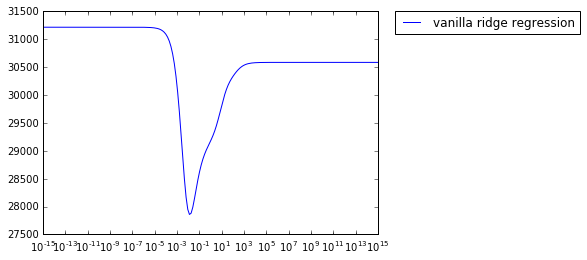

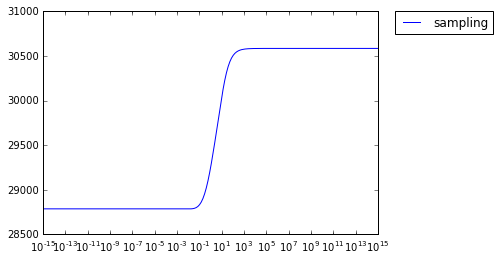

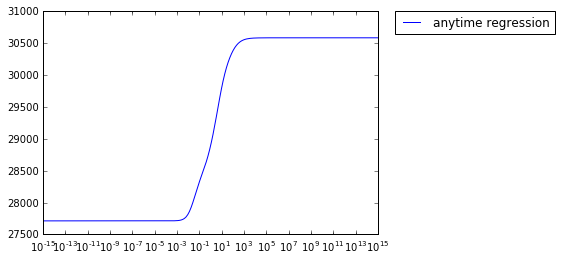

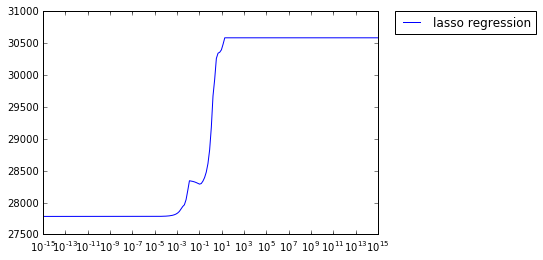

In [322]:
error_total = []
# vanilla ridge regreesion on unmodified training data
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = vanilla_ridge_regression(X_train,y_train,lam[i])
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error'
#print error
plot(error,lam, label = 'vanilla ridge regression')
error_total.append(error)

# sampling method
# vanilla ridge regression on modified training data
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = vanilla_ridge_regression(X_train_mod,y_train,lam[i])
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error'
#print error
plot(error,lam,label='sampling')
error_total.append(error)

# simulated regression 
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = simulate_regression(X_train,y_train,lam[i],p)
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error '
#print error
plot(error,lam,label='simulated regression')
error_total.append(error)

# Anytime regression
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = anytime_regression_l2(X_train,y_train,lam[i],p)
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error '
#print error
plot(error,lam,label='anytime regression')
error_total.append(error)

# Anytime regularization
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = anytime_regularization(X_train,y_train,lam[i],p)
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error '
#print error
plot(error,lam,label='anytime regularization')
error_total.append(error)

# vanilla lasso
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = vanilla_lasso_regression(X_train,y_train,lam[i])
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error '
#print error
plot(error,lam,label='lasso regression')
error_total.append(error)

In [323]:
fig, ax = plt.subplots()
ax.plot(lam,error_total[0], label='ridge regression')
ax.plot(lam,error_total[1], label='sampling')
ax.plot(lam,error_total[2], label='simulated regression')
ax.plot(lam,error_total[3], label='anytime regression')
ax.plot(lam,error_total[4], label='anytime regularization')
ax.plot(lam,error_total[5], label='lasso regression')
#ax.plot(lam,error_total[5], label='baseline')
ax.set_xscale('log')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend(loc=0)
ax.set_xlabel('lambda')
ax.set_ylabel('average error')
plt.savefig('diabete_draft.pdf')
plt.show()

# UCI wine data

In [324]:
test_data_home = tempfile.mkdtemp()
llfw = fetch_mldata('uci-20070111-wine', data_home=test_data_home)
X = llfw.data
#X = preprocessing.normalize(X, norm='l2')
y = llfw.target


In [325]:
X = llfw.data
X = preprocessing.normalize(X, norm='l2')
y = llfw.target


In [333]:
X_train = np.array(X[0:X.shape[0]/2,:])
y_train = np.array(y[0:X.shape[0]/2])
X_test = np.array(X[X.shape[0]/2:,:])
y_test = np.array(y[X.shape[0]/2:])

In [334]:
#p = np.random.rand(X.shape[1])
#p = np.array([0.2, 0.8, 0.6, 0.1])
p = np.array([0.6,0.4,0.1,0.2])
#w = np.random.rand(X.shape[1])
X_train_mod = modify_data(X_train,X_train,p)
X_test = modify_data(X_test,X_train,p)

In [335]:
print 'p'
print p

p
[ 0.6  0.4  0.1  0.2]


In [336]:
X_train.shape

(89, 4)

In [337]:
error_total = []

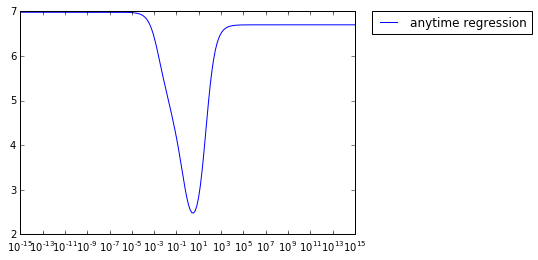

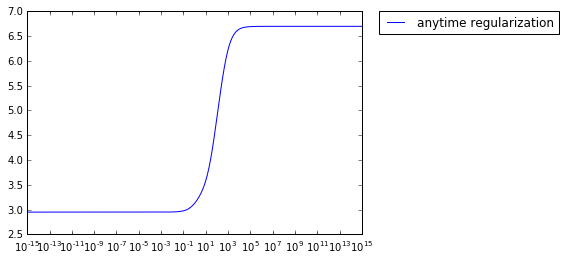

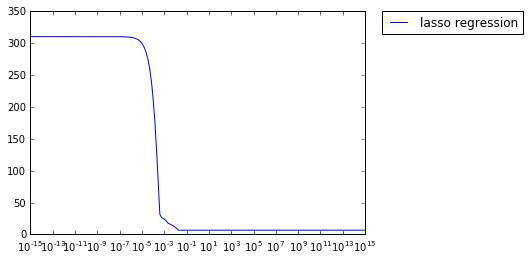

In [338]:
# vanilla ridge regreesion on unmodified training data
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = vanilla_ridge_regression(X_train,y_train,lam[i])
    #print  w_vrr,
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error'
#print error
plot(error,lam, label = 'vanilla ridge regression')
error_total.append(error)

# sampling method
# vanilla ridge regression on modified training data
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = vanilla_ridge_regression(X_train_mod,y_train,lam[i])
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error'
#print error
plot(error,lam,label='sampling')
error_total.append(error)

# simulated regression 
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = simulate_regression(X_train,y_train,lam[i],p)
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error '
#print error
plot(error,lam,label='simulated regression')
error_total.append(error)

# Anytime regression
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = anytime_regression_l2(X_train,y_train,lam[i],p)
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error '
#print error
plot(error,lam,label='anytime regression')
error_total.append(error)

# Anytime regularization
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = anytime_regularization(X_train,y_train,lam[i],p)
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error '
#print error
plot(error,lam,label='anytime regularization')
error_total.append(error)

# vanilla lasso
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = vanilla_lasso_regression(X_train,y_train,lam[i])
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error '
#print error
plot(error,lam,label='lasso regression')
error_total.append(error)

In [339]:
fig, ax = plt.subplots()
ax.plot(lam,error_total[0], label='ridge regression')
ax.plot(lam,error_total[1], label='sampling')
ax.plot(lam,error_total[2], label='simulated regression')
ax.plot(lam,error_total[3], label='anytime regression')
ax.plot(lam,error_total[4], label='anytime regularization')
#ax.plot(lam,error_total[5], label='lasso regression')
#ax.plot(lam,error_total[5], label='baseline')
ax.set_xscale('log')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend(loc=0)
ax.set_xlabel('lambda')
ax.set_ylabel('average error')
plt.savefig('wine_draft.pdf')
plt.show()

# uci-20070111-waveform-5000

In [226]:
test_data_home = tempfile.mkdtemp()
lfw = fetch_mldata('uci-20070111-waveform-5000', data_home=test_data_home)


In [237]:
y = lfw.data
X = preprocessing.normalize(X)
X = lfw.target.T

In [238]:
X_train = np.array(X[0:X.shape[0]/2,:])
y_train = np.array(y[0:X.shape[0]/2])
X_test = np.array(X[X.shape[0]/2:,:])
y_test = np.array(y[X.shape[0]/2:])

In [125]:
"""
X_train_sum = np.sum(X_train,axis=0)
X_train_mean = np.mean(X_train,axis=0)
X_test_mean = np.mean(X_test,axis=0)
X_test_sum = np.sum(X_test,axis=0)
X_train = (X_train - np.matlib.repmat(X_train_mean,X_train.shape[0],1))/X_train_sum
X_test = (X_test - np.matlib.repmat(X_test_mean,X_test.shape[0],1))/X_test_sum
"""

'\nX_train_sum = np.sum(X_train,axis=0)\nX_train_mean = np.mean(X_train,axis=0)\nX_test_mean = np.mean(X_test,axis=0)\nX_test_sum = np.sum(X_test,axis=0)\nX_train = (X_train - np.matlib.repmat(X_train_mean,X_train.shape[0],1))/X_train_sum\nX_test = (X_test - np.matlib.repmat(X_test_mean,X_test.shape[0],1))/X_test_sum\n'

In [239]:
ww =(vanilla_ridge_regression(X_train,y_train,1000)).tolist()
ww = [1/abs(i[0]) for i in ww]
print ww
max_p = max(ww)
print max_p
p = np.array([i/max_p for i in ww])

[672.3420795073108, 283.88821883647506, 62.77279547306927, 46.441216363576736, 29.06785279917031, 18.282474882545294, 50.726503891363336, 194.94844588946117, 16.825715227950667, 11.61623120121164, 11.210029343613792, 15.842190614806366, 14.370871171767915, 25.28079523448619, 376.5676811722589, 46.304368193086766, 65.58882770219832, 93.15386244107009, 2331.3872496727154, 50.848603729470476, 256.5960592291131, 7169.682581620851, 3659.797316639197, 389.6008529084977, 119.51007390626337, 75.11128562216106, 69.71366132187146, 174.212472542826, 248.1721096121414, 4486.2693637365865, 157.81774284129614, 225.71921528721404, 828.2915943867968, 104.03061190442422, 246.80887010043665, 394.64175544781637, 89.15020088707519, 118.48134932871889, 142.11231075655186, 1031.3979591842644]
7169.68258162


In [240]:
p

array([ 0.09377571,  0.03959565,  0.00875531,  0.00647744,  0.00405427,
        0.00254997,  0.00707514,  0.02719067,  0.00234679,  0.00162019,
        0.00156353,  0.00220961,  0.00200439,  0.00352607,  0.05252222,
        0.00645836,  0.00914808,  0.01299275,  0.32517301,  0.00709217,
        0.03578904,  1.        ,  0.51045458,  0.05434004,  0.01666881,
        0.01047624,  0.0097234 ,  0.02429849,  0.0346141 ,  0.62572775,
        0.02201182,  0.03148246,  0.11552695,  0.01450979,  0.03442396,
        0.05504313,  0.01243433,  0.01652533,  0.01982128,  0.14385546])

In [241]:
#X_train *= 100
#X_test *= 100
#p = np.random.rand(X.shape[1])
#print p
X_train_mod = modify_data(X_train,X_train,p)
X_test = modify_data(X_test,X_train,p)

In [242]:
X_train_mod

array([[-0.01808 ,  0.330324,  0.630688, ..., -0.005124,  0.014904,
         0.016852],
       [-0.01808 ,  0.330324,  0.630688, ..., -0.005124,  0.014904,
         0.016852],
       [-0.01808 ,  1.      ,  0.630688, ..., -0.005124,  0.014904,
         0.016852],
       ..., 
       [-0.01808 ,  0.330324,  0.630688, ..., -0.005124,  0.014904,
         0.016852],
       [-0.01808 ,  0.330324,  0.630688, ..., -0.005124,  0.014904,
         0.016852],
       [-0.01808 ,  0.330324,  0.630688, ..., -0.005124,  0.014904,
         0.016852]])

In [243]:
X_test

array([[-0.01808 ,  0.330324,  0.630688, ..., -0.005124,  0.014904,
         0.016852],
       [-0.01808 ,  0.330324,  0.630688, ..., -0.005124,  0.014904,
         0.016852],
       [-0.01808 ,  0.330324,  0.630688, ..., -0.005124,  0.014904,  0.67    ],
       ..., 
       [ 0.64    ,  0.330324,  0.630688, ..., -0.005124,  0.014904,
         0.016852],
       [-0.01808 ,  0.330324,  0.630688, ..., -0.005124,  0.014904,
         0.016852],
       [-0.01808 ,  0.330324,  0.630688, ..., -0.005124,  0.014904,  0.61    ]])

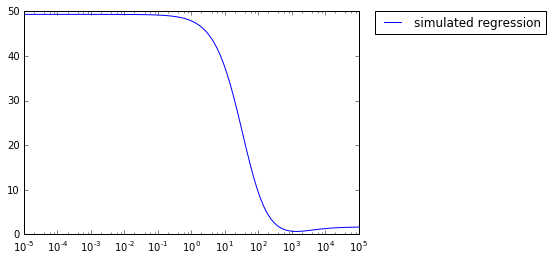

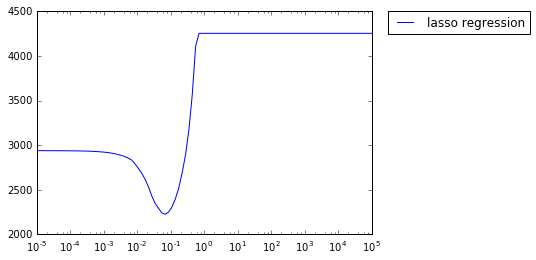

In [244]:
error_total = []
# vanilla ridge regreesion on unmodified training data
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = vanilla_ridge_regression(X_train,y_train,lam[i])
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error'
#print error
plot(error,lam, label = 'vanilla ridge regression')
error_total.append(error)

# sampling method
# vanilla ridge regression on modified training data
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = vanilla_ridge_regression(X_train_mod,y_train,lam[i])
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error'
#print error
plot(error,lam,label='sampling')
error_total.append(error)

# simulated regression 
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = simulate_regression(X_train,y_train,lam[i],p)
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error '
#print error
plot(error,lam,label='simulated regression')
error_total.append(error)

# Anytime regression
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = anytime_regression_l2(X_train,y_train,lam[i],p)
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error '
#print error
plot(error,lam,label='anytime regression')
error_total.append(error)

# Anytime regularization
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = anytime_regularization(X_train,y_train,lam[i],p)
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error '
#print error
plot(error,lam,label='anytime regularization')
error_total.append(error)

# vanilla lasso
error = np.zeros(lam.shape[0],)
#print 'weight'
for i in range(lam.shape[0]):
    w_vrr = vanilla_lasso_regression(X_train,y_train,lam[i])
    #print  w_vrr
    error[i] = prediction_error(X_test,y_test,w_vrr)
#print 'error '
#print error
plot(error,lam,label='lasso regression')
error_total.append(error)

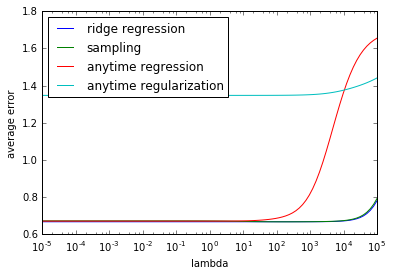

In [246]:
fig, ax = plt.subplots()
ax.plot(lam,error_total[0], label='ridge regression')
ax.plot(lam,error_total[1], label='sampling')
#ax.plot(lam,error_total[2], label='simulated regression')
ax.plot(lam,error_total[3], label='anytime regression')
ax.plot(lam,error_total[4], label='anytime regularization')
#ax.plot(lam,error_total[5], label='lasso regression')
#ax.plot(lam,error_total[5], label='baseline')
ax.set_xscale('log')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend(loc=0)
ax.set_xlabel('lambda')
ax.set_ylabel('average error')
plt.savefig('waveform_draft.pdf')
plt.show()

In [348]:
X = [[1,1,1,1,1,-1,1,-1,-1,-1],[1,1,-1,-1,-1,1,-1,-1,-1,-1]]
X = np.array(X).T
y = np.array([1,1,1,1,1,-1,-1,-1,-1,-1])

In [349]:
w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)